# AI Applications - Mini Project 2
> By Oliver Dietsche & Simon Peier

## Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image

## Dataset
We decided to use part of the [Tiny ImageNet](https://www.kaggle.com/c/tiny-imagenet) dataset. 

According to the description in Kaggle, the Tiny ImageNet dataset has the following properties: "Tiny ImageNet contains 200 classes for training. Each class has 500 images. The test set contains 10,000 images. All images are 64x64 colored ones." It fulfills all the required key characteristics, except that it has too many classes (and thus too many samples). To meet all criteria, we pre-processed the data-set and chose 6 classes to use. As the dataset contains lots of classes of different categories, we settled for classes from the animal realm.

### Dataset import

In [2]:
data_dir = "dataset"
words_file = os.path.join(data_dir, "words.txt")
image_size = (64, 64)

# Load words.txt
with open(words_file, 'r') as f:
    class_labels = {}
    for line in f:
        line = line.strip().split('\t')
        class_labels[line[0]] = line[1]

label_to_int_map = {label: i for i, label in enumerate(class_labels.values())}

def label_to_int(label):
    return label_to_int_map[label]

def int_to_label(intVal):
    return list(label_to_int_map.keys())[intVal]

# Load images and labels
images = []
labels = []

for folder_name in os.listdir(data_dir):
    if folder_name.startswith('n'):
        label = class_labels[folder_name]
        image_folder_path = os.path.join(data_dir, folder_name, "images")
        for image_name in os.listdir(image_folder_path):
            image_path = os.path.join(image_folder_path, image_name)
            image = img_to_array(load_img(image_path))
            images.append(image)
            labels.append(label)

images = np.array(images)
labels = np.array(labels)

### Normalization

In [3]:
print(f"Range of pixel values: [{images.min()};{images.max()}]")

images = images / 255.0

print(f"Range of pixel values: [{images.min()};{images.max()}]")

Range of pixel values: [0.0;255.0]
Range of pixel values: [0.0;1.0]


### Dataset split

The percentages for splitting the dataset into training, testing and validation images we used typical values that are well established and mentioned in the task instructions.

In [4]:
# split into test and training data
train_val_imgs, test_imgs, train_val_labels, test_labels = train_test_split(images, labels, test_size=0.3)

In [5]:
# split into training and validation data
train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_val_imgs, train_val_labels, test_size=0.2)

### Visualization

Total samples:       3000
Testing samples:     900
Training samples:    1680
Validation samples:  420

Image height:        64
Image width:         64
Number of channels:  3


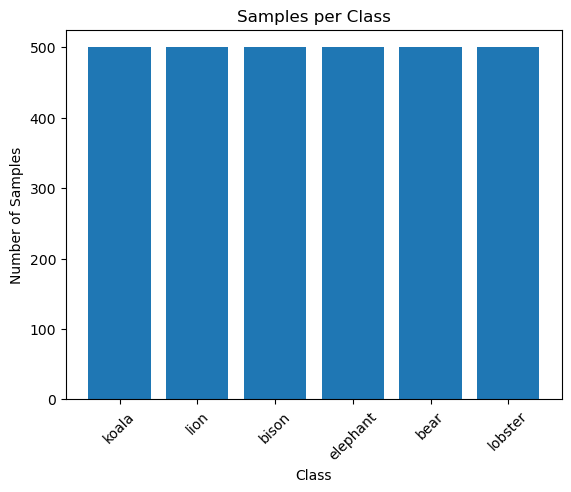

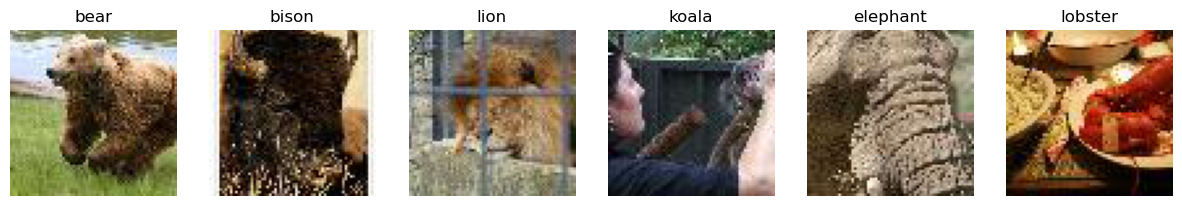

In [6]:
# Collect and print image stats
(total_samples, image_height, image_width, num_channels) = images.shape
test_samples = test_imgs.shape[0]
train_samples = train_imgs.shape[0]
val_samples = val_imgs.shape[0]
print(f"Total samples:       {total_samples}")
print(f"Testing samples:     {test_samples}")
print(f"Training samples:    {train_samples}")
print(f"Validation samples:  {val_samples}\n")
print(f"Image height:        {image_height}")
print(f"Image width:         {image_width}")
print(f"Number of channels:  {num_channels}")

# Count samples per class
samples_per_class = {}
for label in labels:
    samples_per_class[label] = samples_per_class.get(label, 0) + 1

# Determine if dataset is balanced
class_labels = list(samples_per_class.keys())
class_counts = list(samples_per_class.values())
plt.bar(class_labels, class_counts)
plt.title('Samples per Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

# Plot sample image for every class
num_samples_to_plot = 6
classes_to_plot = np.random.choice(list(samples_per_class.keys()), num_samples_to_plot, replace=False)

fig, axs = plt.subplots(1, num_samples_to_plot, figsize=(15, 3))

for i, class_label in enumerate(classes_to_plot):
    class_indices = np.where(labels == class_label)[0]
    sample_index = np.random.choice(class_indices)
    sample_image = images[sample_index]
    axs[i].imshow(sample_image)
    axs[i].set_title(class_label)
    axs[i].axis('off')

plt.show()

## Underfitting
### Model definition

- With a kernel size of 3x3 and depth of 8 we're defining a model that is too primitive to learn all features of our dataset.
- Because the strides are 3x3, there is no overlapping.
- Because 64%3 isn't 0, we use padding to don't miss a column or row

In [7]:
num_classes = len(class_labels)

model = models.Sequential([
    layers.Conv2D(8, 3, padding='same', activation='relu', strides=3, input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D(4),
    layers.Flatten(),
    layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 6)                 1206      
                                                                 
Total params: 1,430
Trainable params: 1,430
Non-trainable params: 0
_________________________________________________________________


### Training

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

train_labels_int = np.array([label_to_int(l) for l in train_labels])
val_labels_int = np.array([label_to_int(l) for l in val_labels])

history = model.fit(train_imgs, train_labels_int, epochs=200, 
                    validation_data=(val_imgs, val_labels_int))

Epoch 1/200
 1/53 [..............................] - ETA: 7s - loss: 1.9816 - accuracy: 0.1562

2024-05-06 21:31:04.940173: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


53/53 [==============================] - 0s 3ms/step - loss: 1.8262 - accuracy: 0.1792 - val_loss: 1.7828 - val_accuracy: 0.2071
Epoch 2/200
53/53 [==============================] - 0s 2ms/step - loss: 1.7646 - accuracy: 0.2458 - val_loss: 1.7205 - val_accuracy: 0.2976
Epoch 3/200
53/53 [==============================] - 0s 2ms/step - loss: 1.7038 - accuracy: 0.2964 - val_loss: 1.6365 - val_accuracy: 0.3667
Epoch 4/200
53/53 [==============================] - 0s 2ms/step - loss: 1.6249 - accuracy: 0.3625 - val_loss: 1.5500 - val_accuracy: 0.4333
Epoch 5/200
53/53 [==============================] - 0s 2ms/step - loss: 1.5559 - accuracy: 0.3952 - val_loss: 1.4978 - val_accuracy: 0.4405
Epoch 6/200
53/53 [==============================] - 0s 2ms/step - loss: 1.5059 - accuracy: 0.4256 - val_loss: 1.4470 - val_accuracy: 0.4524
Epoch 7/200
53/53 [==============================] - 0s 2ms/step - loss: 1.4615 - accuracy: 0.4429 - val_loss: 1.4182 - val_accuracy: 0.4476
Epoch 8/200
53/53 [======

### Plotting

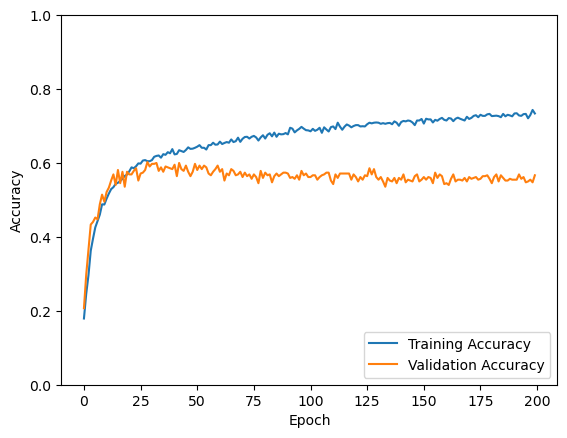

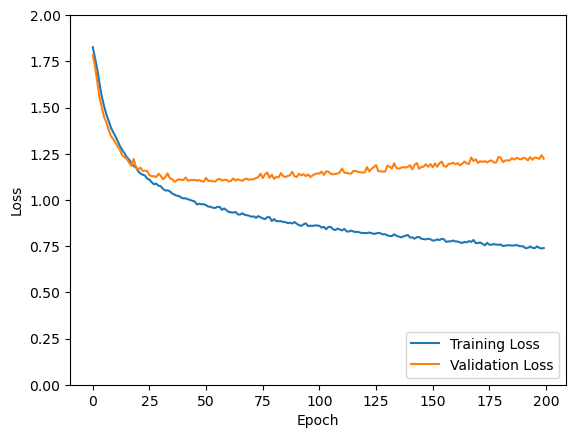

In [9]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')
plt.show()

- Both the training and validation accuracy have a big increase in accuracy in the first few epochs but it quickly stagnates around 60% accuracy. This is an indicator that the model might not be able to capture the complexity our categorization within the defined layers.
- The loss graph also performs very poorly. The Training Loss bottoms out at around 0.75 - a sign that the model is underfitted. The validation loss actually gets worse over time.

14/14 [==============================] - 0s 1ms/step


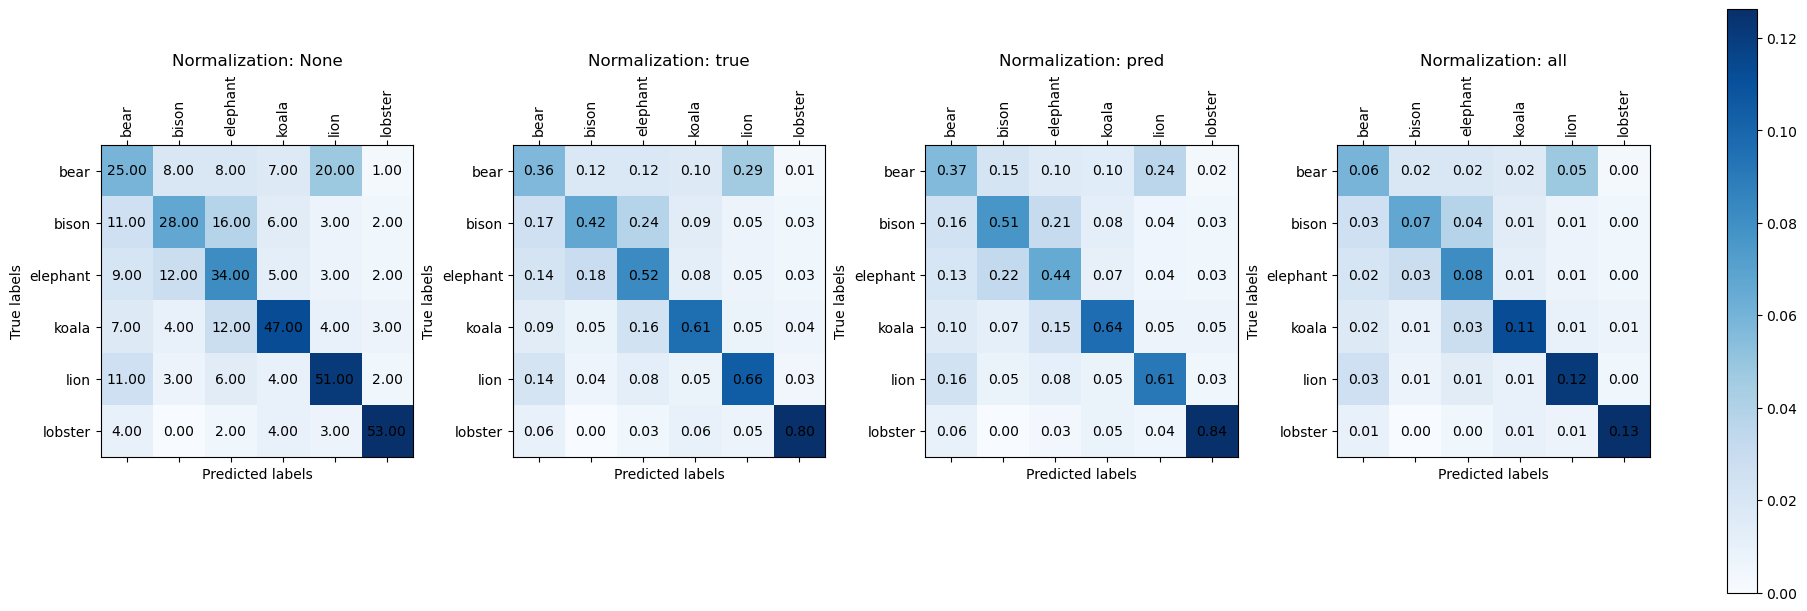

In [10]:
predictions = model.predict(val_imgs)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [int_to_label(l) for l in predicted_labels]

labels = np.unique(val_labels)

fig, axes = plt.subplots(1, 4, figsize=(18, 6), constrained_layout=True)

norm_options = [None, 'true', 'pred', 'all']

for ax, norm in zip(axes, norm_options):
    cm = confusion_matrix(val_labels, predicted_labels, normalize=norm)
    
    disp = ax.matshow(cm, cmap='Blues')
    ax.set_title(f'Normalization: {str(norm)}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{cm[i, j]:.2f}',
                           ha="center", va="center", color="black")

fig.colorbar(disp, ax=axes, orientation='vertical')
plt.show()

- Images of bears get classified as lions 29% of the time. Compared to the 36% they get correctly classified as bears, this shows that they have simmilar features and the model is having a hard time differanciating between them.
- With a success rate of 66% the model is able to identify lions much better and only mistakes them for bears 14% of the time.
- Bisons and elephants also seem to have simmilar features.

## Overfitting
### Model definition

- With 4 Conv2D layers having a 4x4 kernel, increasing filters from 48 to 128 and strides of 1x1 we ensure that our model is overfitting.
- We added a second dense layer to decrease more gradually to our 6 classes.
- We're using the softmax function on the last dense layer. It is the first choice for multi-class classification, because it smooths out the decision boundaries between classes. This also results in receiving probabilities instead of logits.

In [11]:
overfitting_model = models.Sequential([
    layers.Conv2D(48, 4, activation='relu', padding='same', input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 4, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(96, 4, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 4, activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(48),
    layers.Dense(num_classes, activation='softmax')
])

overfitting_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 48)        2352      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        49216     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 96)        98400     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 96)        

### Training

- 40 epochs are plenty to reach a training loss of close to 0 and a accuracy of close to 1

In [12]:
overfitting_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = overfitting_model.fit(train_imgs, train_labels_int, epochs=40, 
                    validation_data=(val_imgs, val_labels_int))

Epoch 1/40
53/53 [==============================] - 5s 92ms/step - loss: 1.6482 - accuracy: 0.2786 - val_loss: 1.5033 - val_accuracy: 0.4262
Epoch 2/40
53/53 [==============================] - 4s 80ms/step - loss: 1.3991 - accuracy: 0.4548 - val_loss: 1.2510 - val_accuracy: 0.5405
Epoch 3/40
53/53 [==============================] - 4s 79ms/step - loss: 1.3043 - accuracy: 0.5060 - val_loss: 1.1940 - val_accuracy: 0.5619
Epoch 4/40
53/53 [==============================] - 4s 80ms/step - loss: 1.1888 - accuracy: 0.5363 - val_loss: 1.1700 - val_accuracy: 0.5786
Epoch 5/40
53/53 [==============================] - 5s 86ms/step - loss: 1.1418 - accuracy: 0.5601 - val_loss: 1.0923 - val_accuracy: 0.5929
Epoch 6/40
53/53 [==============================] - 4s 84ms/step - loss: 1.0334 - accuracy: 0.6125 - val_loss: 1.1550 - val_accuracy: 0.5476
Epoch 7/40
53/53 [==============================] - 4s 82ms/step - loss: 0.9333 - accuracy: 0.6518 - val_loss: 1.0366 - val_accuracy: 0.6143
Epoch 8/40
53

### Plotting

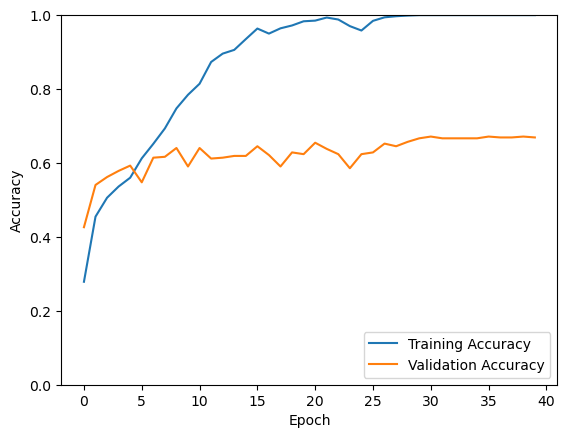

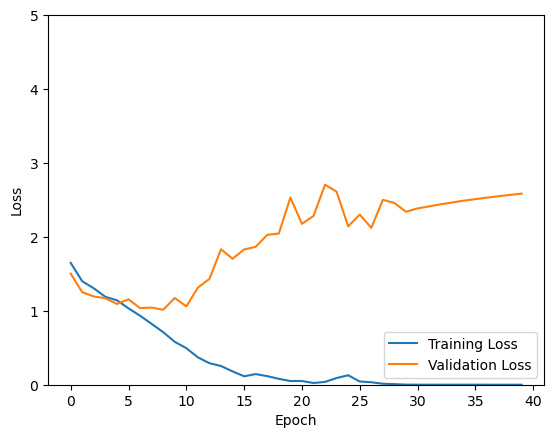

In [13]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='lower right')
plt.show()

- The training accuracy increases continuously, reaching very high values, as the model memorizes the training data and is able to classify it accurately. The validation accuracy on the other hand increases initially, but after a certain time it plateaus, because the model becomes too specialized to the training data.
- The training loss steadily decreases up until a certain point when it reaches very low values. This indicates, that the model is fitting the data extremely well. However the validation loss, after initially decreasing, begins to increase once the model starts overfitting.
- Our model behaves as predicted.

14/14 [==============================] - 0s 26ms/step


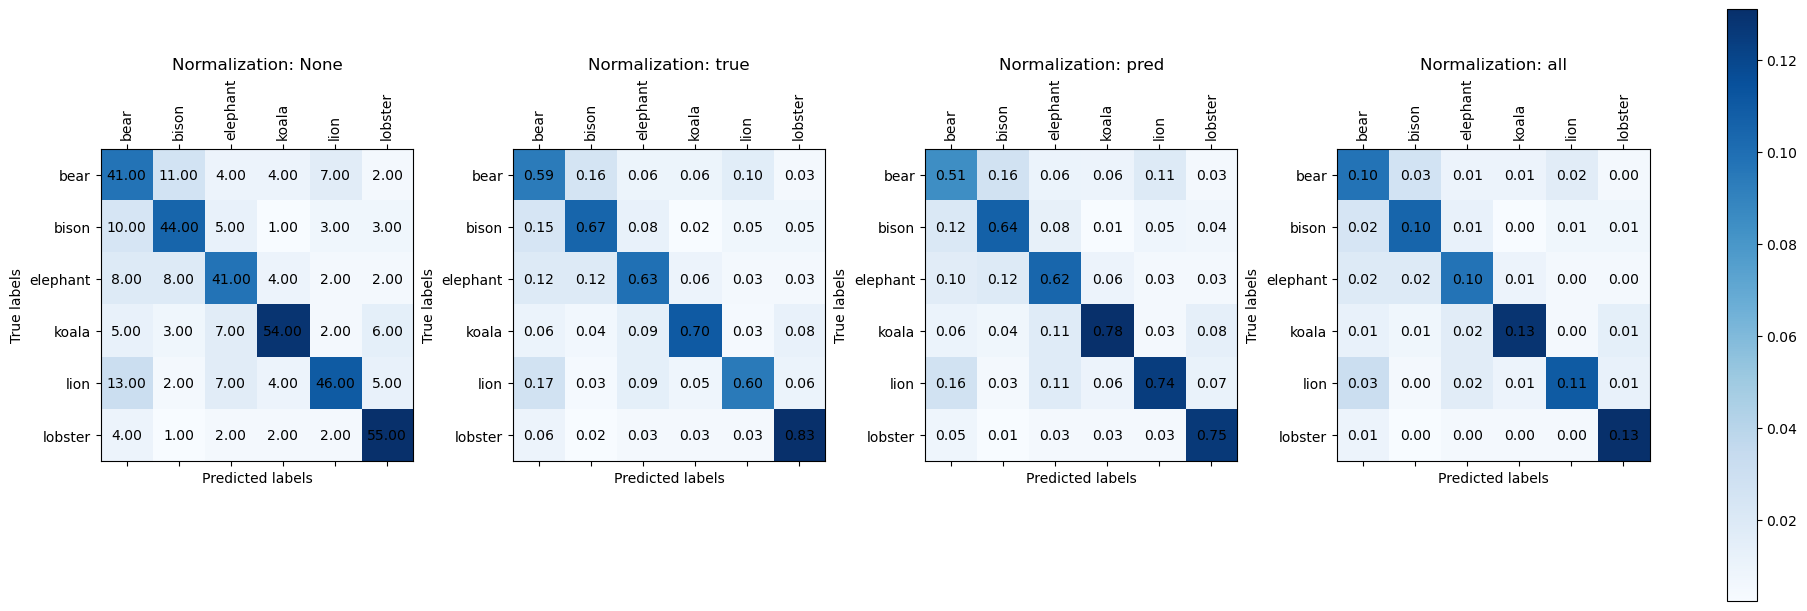

In [14]:
predictions = overfitting_model.predict(val_imgs)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [int_to_label(l) for l in predicted_labels]

labels = np.unique(val_labels)

fig, axes = plt.subplots(1, 4, figsize=(18, 6), constrained_layout=True)

norm_options = [None, 'true', 'pred', 'all']

for ax, norm in zip(axes, norm_options):
    cm = confusion_matrix(val_labels, predicted_labels, normalize=norm)
    
    disp = ax.matshow(cm, cmap='Blues')
    ax.set_title(f'Normalization: {str(norm)}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{cm[i, j]:.2f}',
                           ha="center", va="center", color="black")

fig.colorbar(disp, ax=axes, orientation='vertical')
plt.show()

## Optimizing
### Model definition

- Using radical dropouts of 50% in between Conv2D layers has prooven to work well in our case.
- A kernel regularization value of 0.0055 yielded the best results for us.

In [15]:
k_reg = 0.0055

optimized_model = models.Sequential([
    layers.Conv2D(48, 4, kernel_regularizer=l2(k_reg), activation='relu', padding='same', input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D(2),
    layers.Dropout(0.5),
    layers.Conv2D(64, 4, kernel_regularizer=l2(k_reg), activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.5),
    layers.Conv2D(96, 4, kernel_regularizer=l2(k_reg), activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.5),
    layers.Conv2D(128, 4, kernel_regularizer=l2(k_reg), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(48, kernel_regularizer=l2(k_reg)),
    layers.Dense(num_classes, kernel_regularizer=l2(k_reg), activation='softmax'),
])

optimized_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 48)        2352      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 48)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 48)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        49216     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)       

In [16]:
optimized_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = optimized_model.fit(train_imgs, train_labels_int, epochs=100, 
                    validation_data=(val_imgs, val_labels_int))

Epoch 1/100
53/53 [==============================] - 5s 99ms/step - loss: 3.3060 - accuracy: 0.1964 - val_loss: 2.7395 - val_accuracy: 0.2595
Epoch 2/100
53/53 [==============================] - 5s 97ms/step - loss: 2.3639 - accuracy: 0.2696 - val_loss: 2.1175 - val_accuracy: 0.2929
Epoch 3/100
53/53 [==============================] - 5s 102ms/step - loss: 1.9786 - accuracy: 0.2893 - val_loss: 1.8545 - val_accuracy: 0.2714
Epoch 4/100
53/53 [==============================] - 6s 121ms/step - loss: 1.7998 - accuracy: 0.2869 - val_loss: 1.7440 - val_accuracy: 0.2976
Epoch 5/100
53/53 [==============================] - 5s 101ms/step - loss: 1.7298 - accuracy: 0.2869 - val_loss: 1.6838 - val_accuracy: 0.2786
Epoch 6/100
53/53 [==============================] - 5s 97ms/step - loss: 1.6894 - accuracy: 0.2863 - val_loss: 1.6617 - val_accuracy: 0.2643
Epoch 7/100
53/53 [==============================] - 5s 96ms/step - loss: 1.6499 - accuracy: 0.3030 - val_loss: 1.6104 - val_accuracy: 0.3167
Epo

### Plotting

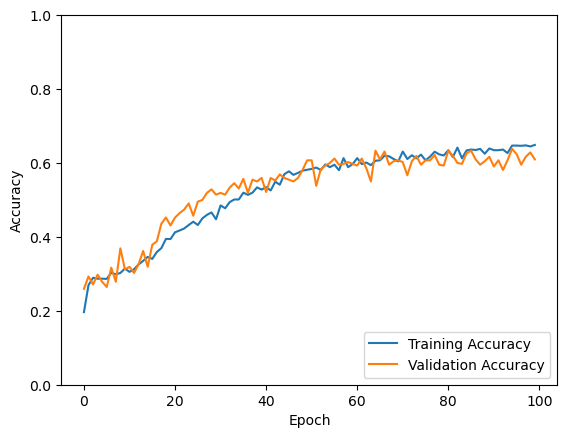

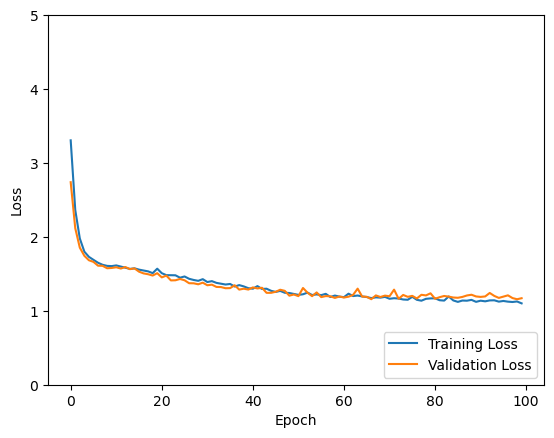

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='lower right')
plt.show()

- Training and validation values stay close to eachother throughout all epochs.
- The accuracy is increasing while the loss in decrease - just as we need them to.
- The accuracy doesn't reach higher than about 60% which might be due to the small amount of 

14/14 [==============================] - 0s 27ms/step


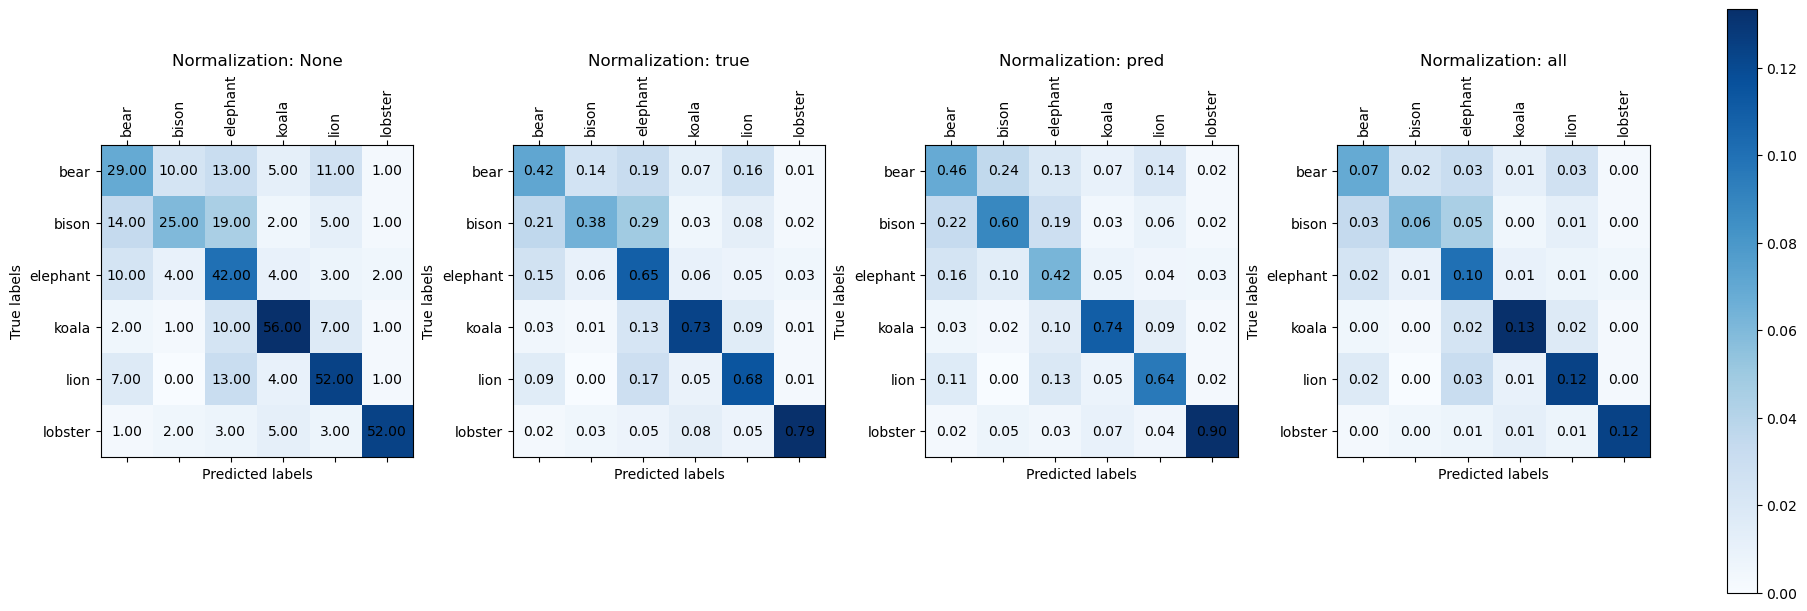

In [18]:
predictions = optimized_model.predict(val_imgs)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [int_to_label(l) for l in predicted_labels]

labels = np.unique(val_labels)

fig, axes = plt.subplots(1, 4, figsize=(18, 6), constrained_layout=True)

norm_options = [None, 'true', 'pred', 'all']

for ax, norm in zip(axes, norm_options):
    cm = confusion_matrix(val_labels, predicted_labels, normalize=norm)
    
    disp = ax.matshow(cm, cmap='Blues')
    ax.set_title(f'Normalization: {str(norm)}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{cm[i, j]:.2f}',
                           ha="center", va="center", color="black")

fig.colorbar(disp, ax=axes, orientation='vertical')
plt.show()